# Autoencoder

# 1. Library

In [1]:
# 필요한 라이브러리 임포트 
from sklearn.preprocessing import MinMaxScaler 
from torch.utils.data import DataLoader, TensorDataset 
import torch  
import pandas as pd

# 2. Data Load

In [2]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

In [3]:
def process_data(df) -> pd.DataFrame:
    numeric_cols = [
        'xmeas_1', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14',
        'xmeas_15', 'xmeas_16', 'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_2',
        'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25',
        'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_3', 'xmeas_30',
        'xmeas_31', 'xmeas_32', 'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36',
        'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_4', 'xmeas_40', 'xmeas_41',
        'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 'xmv_1',
        'xmv_10', 'xmv_11', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6',
        'xmv_7', 'xmv_8', 'xmv_9'
    ]
    return df[numeric_cols]

In [4]:
X_train = process_data(train_data)
X_test = process_data(test_data)

In [22]:
# 데이터 스케일러 인스턴스 생성(데이터 표준화)
scaler = MinMaxScaler() 
# 학습 데이터셋에 대해 fit과 transform 수행: train 기준 정보 계산 및 데이터 변환
X_train_scaled = scaler.fit_transform(X_train) 
# 테스트 데이터셋에 대해서는 transform만 수행: 학습 데이터셋의 기준 정보를 사용하여 데이터 변환
X_test_scaled = scaler.transform(X_test)  

# PyTorch Tensor로 변환 
X_train_tensor = torch.FloatTensor(X_train_scaled) 
X_test_tensor = torch.FloatTensor(X_test_scaled)  

# DataLoader 설정 
train_dataset = TensorDataset(X_train_tensor, X_train_tensor) # 입력과 타겟이 같음 
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [26]:
for data in train_loader:
    inputs = data[0]  # 첫 번째 요소가 입력 데이터
    targets = data[1]  # 두 번째 요소가 타겟 데이터
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)
    # 여기에 데이터 형식에 대한 추가 확인 또는 시각화 코드 추가 가능
    break  # 첫 번째 배치만 확인 + 입력 데이터 

Input shape: torch.Size([64, 52])
Target shape: torch.Size([64, 52])


# 3. Modeling

In [89]:
import torch.nn as nn
import matplotlib.pyplot as plt

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # 인코더 구성
        self.encoder = nn.Sequential(
            nn.Linear(52, 32), # 입력 차원 52에서 중간 차원 64로 압축
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(32, 16), # 중간 차원 64에서 중간 차원 32로 압축
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(16, 8), # 중간 차원 32에서 특징 차원 16으로 더 압축
            nn.ReLU(), # 활성화 함수 ReLU 사용
        )
        # 디코더 구성
        self.decoder = nn.Sequential(
            nn.Linear(8, 16), # 특징 차원 16에서 중간 차원 32로 확장
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(16, 32), # 중간 차원 32에서 중간 차원 64로 확장
            nn.ReLU(), # 활성화 함수 ReLU 사용
            nn.Linear(32, 52), # 중간 차원 64에서 원본 차원인 52로 복원
            nn.Sigmoid() # 출력을 0과 1 사이로 조정
        )
 
    def forward(self, x):
        x = self.encoder(x) # 인코딩
        x = self.decoder(x) # 디코딩
        return x

Epoch 1, Loss: 0.011413291559368944
Epoch 2, Loss: 0.010017589124366316
Epoch 3, Loss: 0.009338689126295523
Epoch 4, Loss: 0.008632611116956485
Epoch 5, Loss: 0.008357946686818529
Epoch 6, Loss: 0.008073809081586022
Epoch 7, Loss: 0.008003584079926875
Epoch 8, Loss: 0.00772721095903106
Epoch 9, Loss: 0.007583302574669396
Epoch 10, Loss: 0.007555923062930418
Epoch 11, Loss: 0.007544775297738934
Epoch 12, Loss: 0.007539721047193468


KeyboardInterrupt: 

# 5. Train

In [ ]:
model = Autoencoder()
criterion = nn.MSELoss() # MSE: Mean Squared Error 
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) # Adam optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
# ReduceLROnPlateau는 손실이 더 이상 개선되지 않을 때 학습률을 감소시키는 방법을 제공

# 손실 기록을 위한 리스트 초기화
losses = []

# 학습 루프
for epoch in range(100):
    epoch_loss = 0.0
    for data in train_loader:
        inputs = data[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
    scheduler.step(epoch_loss)

# Loss 그래프 그리기
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# 6. Inference

In [90]:
import pandas as pd

# 테스트 데이터에 대한 예측 생성
with torch.no_grad():  # 그라디언트 계산 비활성화
    model.eval()  # 모델을 평가 모드로 설정
    test_outputs = model(X_test_tensor)

# 테스트 데이터의 재구성 오차 계산
reconstruction_errors = torch.mean((test_outputs - X_test_tensor) ** 2, axis=1)

# 재구성 오차를 확률로 변환하여 faultNumber가 0일 확률 추정
max_error = torch.max(reconstruction_errors)
probabilities = 1 - (reconstruction_errors / max_error)

# 결과를 pandas DataFrame으로 변환
result_df = pd.DataFrame({
    # 'Sample': range(len(X_test)),  # 샘플 인덱스
    'Probability_faultNumber': probabilities.numpy()  # faultNumber가 0일 확률
})

# 결과 출력
print(result_df)

        Probability_faultNumber
0                      0.999839
1                      0.999814
2                      0.999577
3                      0.999545
4                      0.999608
...                         ...
710395                 0.310727
710396                 0.316619
710397                 0.316618
710398                 0.315417
710399                 0.315416

[710400 rows x 1 columns]


In [91]:
result_df.describe()

,Probability_faultNumber
count,710400.000000
mean,0.980218
std,0.105393
min,0.000000
25%,0.999245
50%,0.999420
75%,0.999527
max,0.999976


In [92]:
# 람다 함수를 사용하여 Probability_faultNumber 열의 값을 조건에 따라 0 또는 그대로 반환
result_df['faultNumber'] = result_df['Probability_faultNumber'].apply(lambda x: 0 if x >= 0.980218 else 1)

In [93]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710400 entries, 0 to 710399
Data columns (total 2 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Probability_faultNumber  710400 non-null  float32
 1   faultNumber              710400 non-null  int64  
dtypes: float32(1), int64(1)
memory usage: 8.1 MB


In [94]:
result_df['faultNumber'].value_counts()

faultNumber
0    662534
1     47866
Name: count, dtype: int64

In [96]:
merged_df = pd.concat([test_data, result_df], axis=1)
counts = merged_df[merged_df['faultNumber']==1].groupby('simulationRun').size()
less_than_500 = counts[counts > 100].index.tolist()
print(len(less_than_500))

90


In [97]:
# less_than_500에 해당하는 simulationRun의 faultNumber를 1로, 나머지는 0으로 설정
merged_df['faultNumber'] = merged_df['simulationRun'].apply(lambda x: 1 if x in less_than_500 else 0)
print(merged_df['faultNumber'] .value_counts())

faultNumber
0    624000
1     86400
Name: count, dtype: int64


In [98]:
merged_df['faultNumber'].to_csv("faultnum_500.csv")

Text(0.5, 1.0, 'reconstruction error distribution')

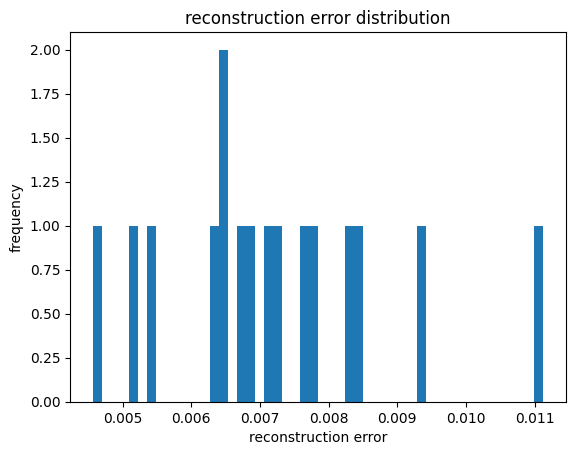

In [36]:
import matplotlib.pyplot as plt  

# reconstruction error 계산 
reconstruction_errors = torch.mean((outputs - inputs) ** 2, axis=1).detach()  #MSE

# reconstruction error 히스토그램 시각화 
plt.hist(reconstruction_errors.numpy(), bins=50) 
plt.xlabel('reconstruction error') 
plt.ylabel('frequency') 
plt.title('reconstruction error distribution')